# Plot possible relations among elements from Inayoshi's catalog

We want to analyze multiwavelength data from several AGNs.  
They have been retrieved from the review from **Inayoshi et al., 2020**,  
combined with the cross-matching between `SDSS QUASAR DR12` catalog and `FIRST` observations.  
Additional observations were also added from the `radio` database catalog,  
compiled by NASA's `HEASARC` team.

In this way, we select sources with observations in radio frequencies.

Previously, we have selected features which can add the most information  
to the analysis. Now, we want to find ways to mixture the features to obtain  
possible correlations among our data.

---

## Python setup

First, we import the packages to be used

To get the first line working, you need  
to run the following lines:

```bash
 conda install nodejs
 pip install ipympl
 pip install --upgrade jupyterlab
 jupyter labextension install @jupyter-widgets/jupyterlab-manager
 jupyter labextension install jupyter-matplotlib
 jupyter nbextension enable --py widgetsnbextension
 ```

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from matplotlib.ticker import FormatStrFormatter
# from matplotlib.patches import Polygon
# from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import hist
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
# from astroquery.simbad import Simbad
# from astroquery.ned import Ned
from scipy.cluster import hierarchy as hc
from scipy.spatial import distance
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
import getpass
import progressbar
import pandas as pd
import re
import missingno as msno
import itertools

Define the spectral index $\alpha$ from different sources  
to be used in the luminosity calculations (K-correction)

In [2]:
alpha_first = 0.5  # From FIRST data (Bornancini+2010)
alpha_RG    = 1.0  # For radio galaxies (Verkhodanov & Khabibullina, 2010)
alpha_alex  = 0.8  # Star-forming galaxies (Alexander+2003)
alpha_smol  = 0.7  # Mean value from VLA-COSMOS 3GHz sample (Smolčić et al. 2017)
alpha_butl  = 0.75  # From Butler et al., 2018

Choose one of the spectral indexes

In [3]:
alpha_used  = alpha_butl

We define the cosmological properties to calculate luminosity distances and other quantities.

In [4]:
cosmo       = FlatLambdaCDM(H0=70, Om0=0.3)

In [5]:
def lum_from_flux_radio(flux, redshift):  # Flux in mJy
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26 * (1 + redshift)**(alpha_used - 1)  # in W/Hz
    return luminosity

In [6]:
def lum_from_flux(flux, redshift):  # Flux in mJy, general version, without K-correction
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26  # in W/Hz
    return luminosity

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [7]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [8]:
cmap            = cm.get_cmap('inferno')
dark_color      = cmap(0.4)  # RGBA color code
light_color     = cmap(0.6)  # RGBA color code
colors          = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_8        = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]

In [9]:
cmap_alt        = cm.get_cmap('summer')
dark_color_alt  = cmap_alt(0.4)  # RGBA color code
light_color_alt = cmap_alt(0.6)  # RGBA color code
colors_alt      = [cmap_alt(0.15), cmap_alt(0.30), cmap_alt(0.45), cmap_alt(0.60), cmap_alt(0.75), cmap_alt(0.90)]
colors_8_alt    = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.60), cmap_alt(0.72),\
                   cmap_alt(0.84), cmap_alt(0.96)]

In [10]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

---

## Reading data

In [11]:
machine  = getpass.getuser()
# cat_path = '/home/' + machine + '/Documentos/Data/'
cat_path = ''  # relative path to the same directory

We import our data using the `pandas` package.  

It is important to keep in mind that columns with keys starting with `Flux Density...` are in `Jy`.  
All the other values, are expressed in `mJy`.

Columns with uncertainties (`NED Uncertainty...`) have been saved as strings, to preserve possible upper limits.

In [12]:
inayoshi_merged_catalog_df = pd.read_hdf(cat_path + 'inayoshi_sources_merged_cat_jun2020.h5', 'df')

In [13]:
np.shape(inayoshi_merged_catalog_df)

(20, 24)

---

In [14]:
inayoshi_merged_catalog_df.columns

Index(['Flux K', 'Flux H', 'Flux J', 'Flux I', 'Flux i', 'Flux r', 'Flux V',
       'Flux B', 'Flux NUV', 'Flux FUV', 'Flux Ly alpha', 'Flux 230-468 MHz',
       'Flux 1.4-1.7 GHz', 'Flux 2.2-5.5 GHz', 'Flux 20-44 GHz',
       'Flux 203-375 GHz', 'Flux 150-500 microns', 'Flux 10-30 microns',
       'Flux 3-8 microns', 'Flux 0.1-12 keV', 'z_val', 'z_val_e',
       'f_10cm_up_l', 'origin'],
      dtype='object')

## Organize data

Separate data into different arrays for calculations

The following redshift column comes from `SDSS` with the highest quality flag selected.

In [15]:
redshift    = inayoshi_merged_catalog_df['z_val']
redshift_e  = inayoshi_merged_catalog_df['z_val_e']
F_20cm_up_l = inayoshi_merged_catalog_df['f_10cm_up_l']
origin_flag = inayoshi_merged_catalog_df['f_10cm_up_l'].astype(int)         # 0:SDSS+FIRST, 1:COSMOS, 2:RADIO, 3:Stripe82, 3:Inayoshi

We can calculate luminosities from fluxes.

In this case, we first select the columns with fluxes in a numerical format  
(with this all error columns are discarded for the moment).

In [16]:
# numeric_col_names = large_catalog_df.select_dtypes('number').columns.drop(['INDEX', 'RA_d', 'DEC_d', 'Z_VALUE', 'FLUX_ERROR_B',\
#                                                                            'Z_OWN_ERR', 'L_20CM', 'L_20CM_ERR', 'L_250GHZ', 'L_250GHZ_ERR',\
#                                                                            'F_20CM_ERR', 'F_250GHZ_ERR', 'MASS_1450', 'FLUX_ERROR_V',\
#                                                                            'FLUX_ERROR_R', 'FLUX_ERROR_I','FLUX_ERROR_J',\
#                                                                            'FLUX_ERROR_K', 'Z_OWN'])
# numeric_col_names = inayoshi_merged_catalog_df.select_dtypes('number').columns.drop(['INDEX', 'RA_d', 'DEC_d', 'Z_VALUE', 'FLUX_ERROR_B',\
#                                                                            'FLUX_ERROR_V', 'FLUX_ERROR_R', 'FLUX_ERROR_I', 'FLUX_ERROR_J',\
#                                                                            'FLUX_ERROR_K','F_250GHZ_ERR', 'F_XMM_ERR','F_1.5GHZ_ERR',\
#                                                                            'F_3GHZ_ERR', 'MASS_1450', 'F_20CM_ERR', 'Z_OWN_ERR', 'Z_OWN',\
#                                                                            'F_6CM_ERR'])

---

## Plot elements

In [17]:
flux_values_df = inayoshi_merged_catalog_df.drop(['z_val', 'z_val_e', 'origin', 'f_10cm_up_l'], axis='columns')

In [18]:
flux_values_df.columns.to_numpy()

array(['Flux K', 'Flux H', 'Flux J', 'Flux I', 'Flux i', 'Flux r',
       'Flux V', 'Flux B', 'Flux NUV', 'Flux FUV', 'Flux Ly alpha',
       'Flux 230-468 MHz', 'Flux 1.4-1.7 GHz', 'Flux 2.2-5.5 GHz',
       'Flux 20-44 GHz', 'Flux 203-375 GHz', 'Flux 150-500 microns',
       'Flux 10-30 microns', 'Flux 3-8 microns', 'Flux 0.1-12 keV'],
      dtype=object)

In [19]:
imputer       = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.00)
imputed_array = imputer.fit_transform(flux_values_df, flux_values_df)

In [20]:
filled_flux_cat_df = pd.DataFrame(imputed_array, columns=flux_values_df.columns)

In [45]:
min_vals = np.heaviside(np.nanmin(flux_values_df), 0) + 0.01
max_vals = np.nanmax(flux_values_df)
bin_vals = np.logspace(start=np.log10(min_vals), stop=np.log10(max_vals), num=40)

In [46]:
min_vals

0.01

In [47]:
bin_vals

array([1.00000000e-02, 2.23094486e-02, 4.97711496e-02, 1.11036690e-01,
       2.47716733e-01, 5.52642373e-01, 1.23291466e+00, 2.75056462e+00,
       6.13635800e+00, 1.36898763e+01, 3.05413592e+01, 6.81360883e+01,
       1.52007856e+02, 3.39121144e+02, 7.56560573e+02, 1.68784492e+03,
       3.76548895e+03, 8.40059821e+03, 1.87412714e+04, 4.18107430e+04,
       9.32774622e+04, 2.08096875e+05, 4.64252652e+05, 1.03572207e+06,
       2.31063882e+06, 5.15490780e+06, 1.15003151e+07, 2.56565687e+07,
       5.72383901e+07, 1.27695692e+08, 2.84882048e+08, 6.35556140e+08,
       1.41789070e+09, 3.16323597e+09, 7.05700502e+09, 1.57437891e+10,
       3.51235253e+10, 7.83586481e+10, 1.74813823e+11, 3.90000000e+11])

/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  """


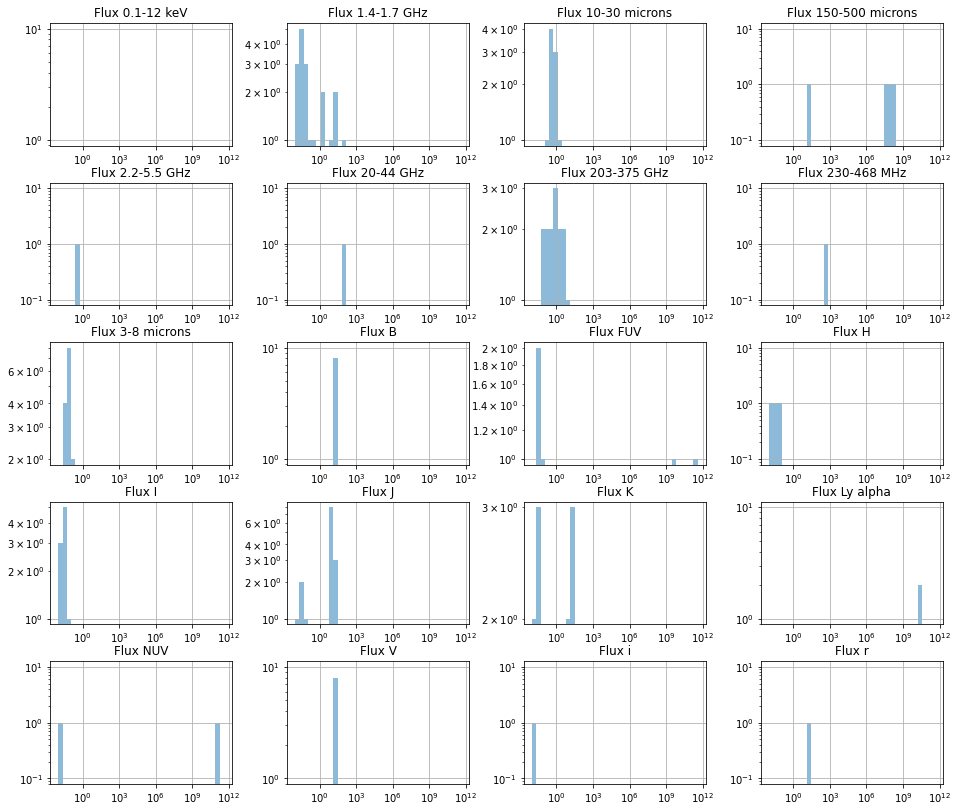

In [48]:
ax1 = flux_values_df.hist(bins=bin_vals, histtype='stepfilled', alpha=0.5, figsize=(16, 14))
for subax in ax1:
    for subb in subax:
        subb.set_xscale('log')
        subb.set_yscale('log')
# ax1.set_xscale('log')
# ax1.set_yscale('log')

In [ ]:
ax2 = flux_values_df.plot.hist(bins=75, histtype='stepfilled', alpha=0.5, loglog=True, figsize=(11, 11))